In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
df=pd.read_csv("SampleSchoolData.csv")

/nas/longleaf/home/yongzhe/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/nas/longleaf/home/yongzhe/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [70]:
##Solve the problem with K-Means that needs clusters
from sklearn.metrics import jaccard_score
from itertools import combinations
import numpy as np

def tokenize(string):
    return set(string.lower().split())

def calculate_jaccard_similarity(str1, str2):
    tokens1 = tokenize(str1)
    tokens2 = tokenize(str2)
    intersection = tokens1.intersection(tokens2)
    union = tokens1.union(tokens2)
    return len(intersection) / len(union)

def group_similar_strings(strings, threshold=0.5):
    groups = []
    for string in strings:
        added = False
        for group in groups:
            if any(calculate_jaccard_similarity(string, s) >= threshold for s in group):
                group.append(string)
                added = True
                break
        if not added:
            groups.append([string])
    return groups


In [77]:
from collections import defaultdict

def group_by_location(df, strings_col, lat_col, long_col):
    location_groups = defaultdict(list)
    for idx, row in df.iterrows():
        rounded_lat = round(row[lat_col])
        rounded_long = round(row[long_col])
        location_key = (rounded_lat, rounded_long)
        location_groups[location_key].append(row[strings_col])
    return location_groups

def apply_jaccard_within_groups(location_groups, threshold=0.5):
    grouped_strings = []
    for location, strings in location_groups.items():
        grouped_strings.extend(group_similar_strings(strings, threshold))
    return grouped_strings


In [86]:
def assign_group_numbers_to_df(df, strings_col, lat_col, long_col, threshold=0.5):
    # Group by location
    location_groups = group_by_location(df, strings_col, lat_col, long_col)

    # Apply Jaccard Index within groups and assign group numbers
    final_groups = {}
    group_number = 1
    for location, strings in location_groups.items():
        jaccard_groups = group_similar_strings(strings, threshold)
        for group in jaccard_groups:
            for address in group:
                final_groups[address] = group_number
            group_number += 1

    # Map group numbers back to the df
    df['Group_Number'] = df[strings_col].map(final_groups)
    return df

grouped_df = assign_group_numbers_to_df(dist, 'Address', 'Latitude', 'Longitude', threshold=0.7)


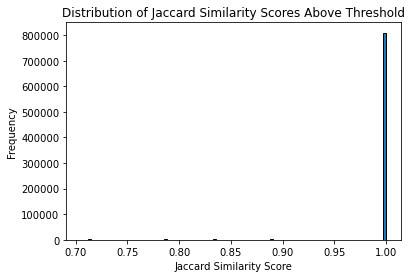

In [93]:
import matplotlib.pyplot as plt
def calculate_jaccard_similarity(str1, str2):
    """ Calculate Jaccard Similarity between two strings """
    tokens1 = set(str1.lower().split())
    tokens2 = set(str2.lower().split())
    intersection = tokens1.intersection(tokens2)
    union = tokens1.union(tokens2)
    return len(intersection) / len(union) if len(union) > 0 else 0

def calculate_similarity_distribution_above_threshold(df, strings_col, lat_col, long_col, threshold=0.5):
    # Store all similarity scores above the threshold
    similarity_scores = []

    # Apply the grouping logic
    location_groups = group_by_location(df, strings_col, lat_col, long_col)
    for _, strings in location_groups.items():
        jaccard_groups = group_similar_strings(strings, threshold)
        for group in jaccard_groups:
            pairs = combinations(group, 2)  # Get all pairs in the group
            for pair in pairs:
                score = calculate_jaccard_similarity(*pair)
                if score > threshold:
                    similarity_scores.append(score)

    return similarity_scores

def plot_similarity_distribution(similarity_scores):
    # Plotting the distribution of similarity scores
    plt.figure(figsize=(15, 10))
    plt.hist(similarity_scores, bins=100, edgecolor='black')
    plt.xlabel('Jaccard Similarity Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of Jaccard Similarity Scores Above Threshold')
    plt.savefig('Distribution_JaccardScore.jpg', format='jpg')
    plt.show()

    
similarity_scores_above_threshold = calculate_similarity_distribution_above_threshold(dist, 'Address', 'Latitude', 'Longitude', threshold=0.7)
plot_similarity_distribution(similarity_scores_above_threshold)


In [104]:
grouped_df['SCHOOL_UNITED'] = grouped_df.groupby('Group_Number')['SCHOOL'].transform('first')

In [10]:
grouped_df

NameError: name 'grouped_df' is not defined